In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data exploration

(720, 1280, 3)


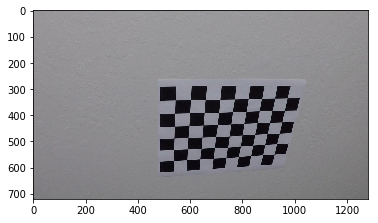

In [2]:
# Data exploration - One of the 20 images used for calibration
img = mpimg.imread("camera_cal/calibration10.jpg")
image_shape = img.shape
print(image_shape)
plt.imshow(img)

To correct the image distortions I first need to identify the locations of the corners on the camera calibration images. These are going to be inputs of my camera calibration function. I used opencv functions findChessboardCorners() and drawChessboardCorners() to do so.

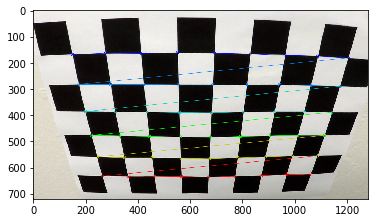

In [3]:
nx = 9
ny = 6

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Arrays to store object points and image points from all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points like (0,0,0), (1,0,0), (2,0,0) .../(7,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates

for fname in images:
    #read in each image
    img = mpimg.imread(fname)

    #Convert the image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Find the chessboard corners
    ret, corners = cv2. findChessboardCorners(gray, (nx,ny), None)

    #If corners are found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)

In [4]:
# Plot original and transformed image next to each other
def print_image(img1, img2, title1, title2, cmap):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    if cmap == 'gray':
        ax2.imshow(img2,cmap = 'gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Calibration and Undistortion 

After identifying the corners I am good to calibrate the camera. To do that I use opencv's calibrateCamera() function, I pass the previously calculated objpoints, imgpoints and the shape of the image as arguments. 
The function returns the distortion coefficients and the camera matrix as well which I need to pass as arguments to the undistort() function which returns my undistorted image. Let's try out!

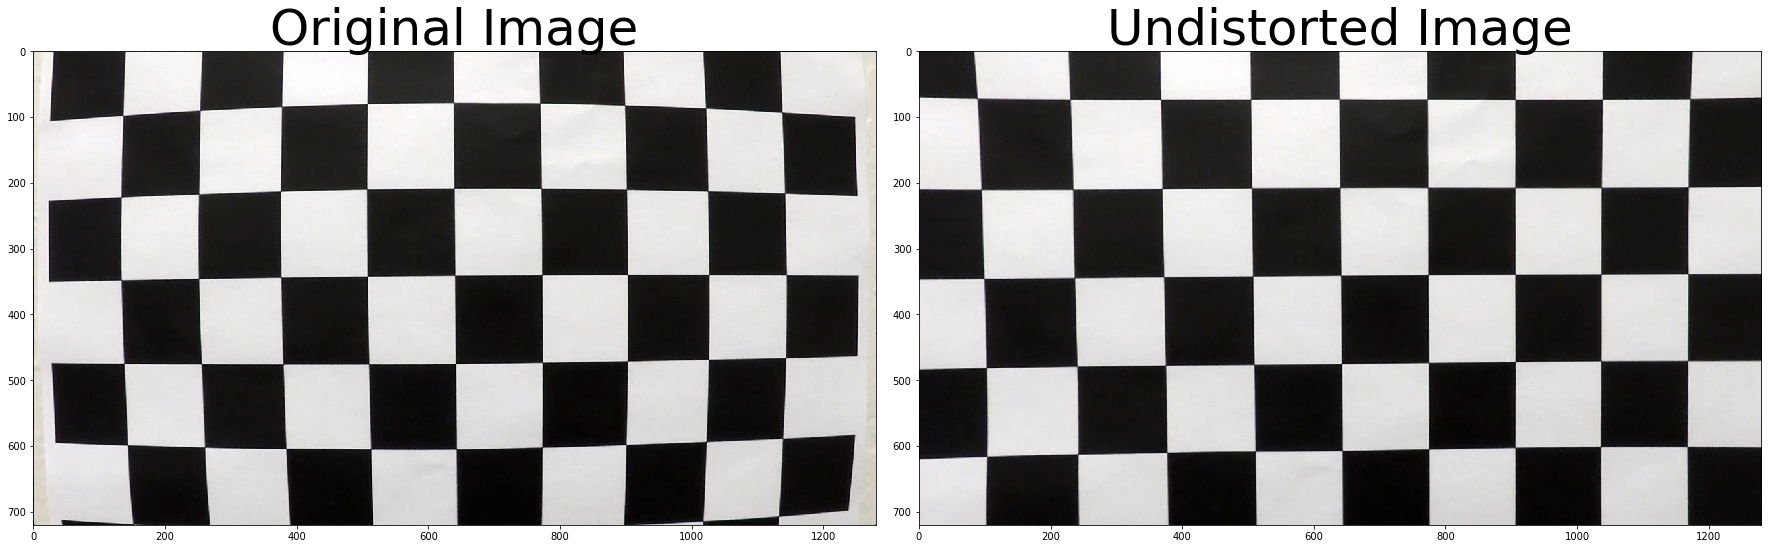

In [5]:
#Camera calibration and undistortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = mpimg.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

print_image(img, dst, 'Original Image', 'Undistorted Image', 'default')

Let's test some real-life images before/after undistortion. 

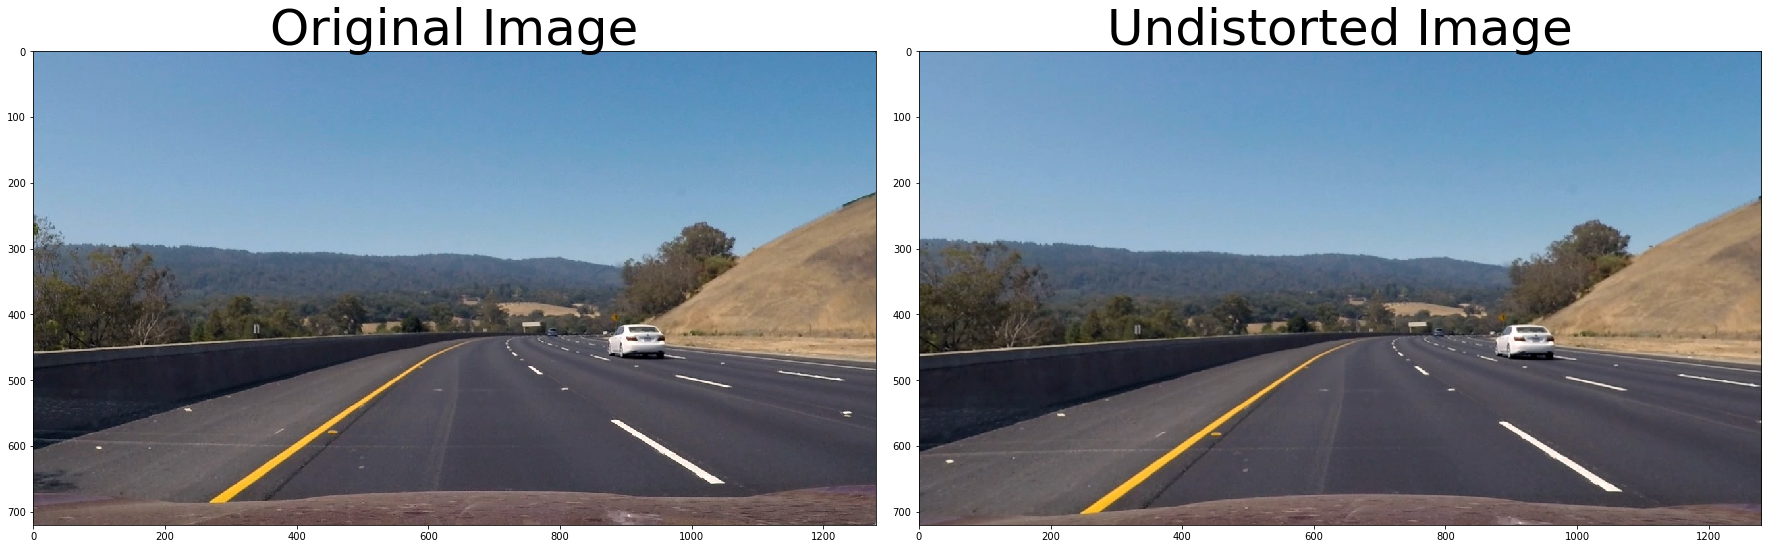

In [6]:
img = mpimg.imread('test_images/test3.jpg')
dst=undistort(img)
print_image(img, dst, 'Original Image', 'Undistorted Image', 'default')

# Perspective Transform

Perspective transform maps the points in a given image to a different, desired, image points with a new perspective. We are most interested in the bird's-eye view transform that let's us vie a lane from above, this will be useful for calculating the lane curvature. 

In [7]:
# Define perspective transform function
def warp(img):
    
    #Define calibration box in source (original) and destination (desired or warped) coordinates
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_size = (img_width, img_height)
    
    #Four source coordinates
    src = np.float32([[img_width*0.44,img_height*0.65],
                      [img_width*0.56,img_height*0.65],
                      [img_width*0.86,img_height*1],
                      [img_width*0.18,img_height*1]])
    
    #Four destination coordinates
    dst = np.float32([[img_width*0.11,img_height*0.001],
                      [img_width*0.72,img_height*0.001],
                      [img_width*0.72,img_height*1],
                      [img_width*0.13,img_height*1]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Inverse perspective transform
    #Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped#, Minv

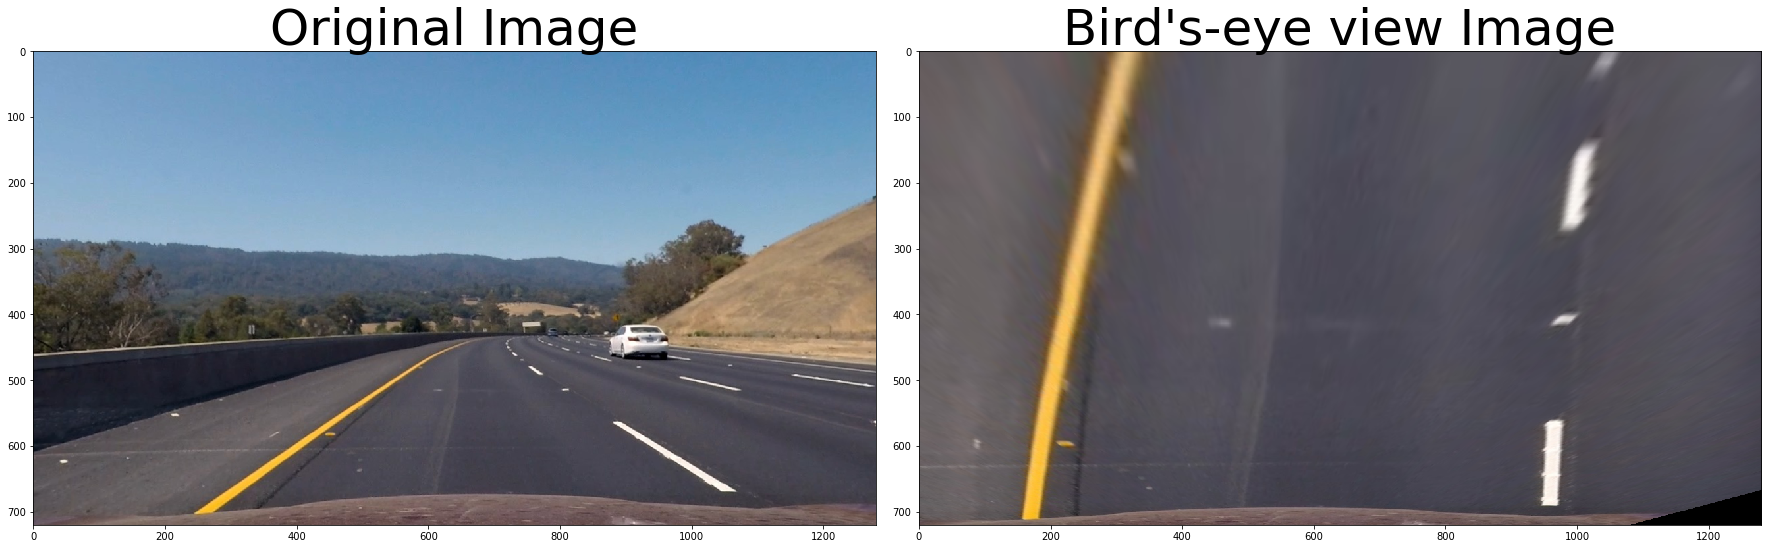

In [67]:
# Test and choose parameters
img = mpimg.imread('test_images/test3.jpg')

# Undistort image
img = undistort(img)

# Transform
img_warp = warp(img)

print_image(img, img_warp, 'Original Image', "Bird's-eye view Image", 'default')

# Thresholding

The ultimate goal is the find the Lane Lines on the road, and there are numerous techniques an image can be thresholded to pick/emphasize a feature of it. Let's examine a few of these.
First let's implement the Sobel operator which takes the derivative of an image in either the x or y direction. 

# Sobel Threshold

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

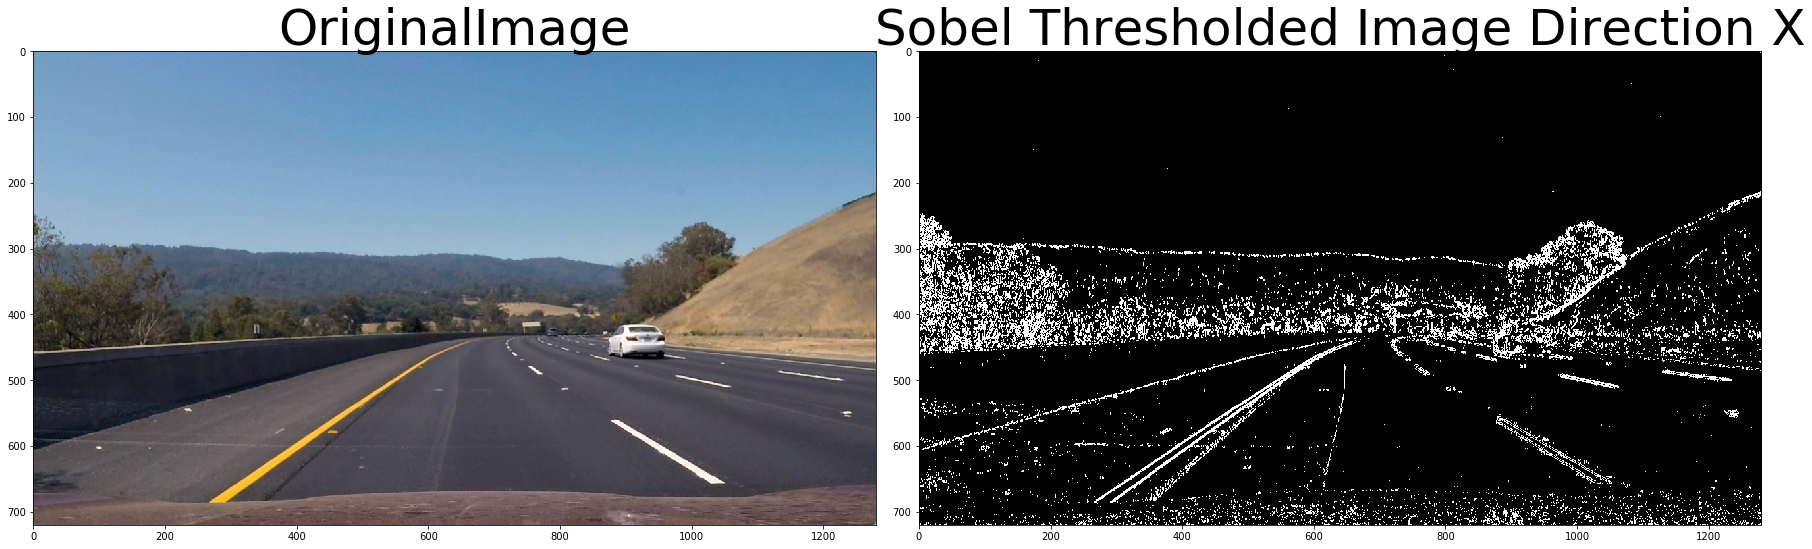

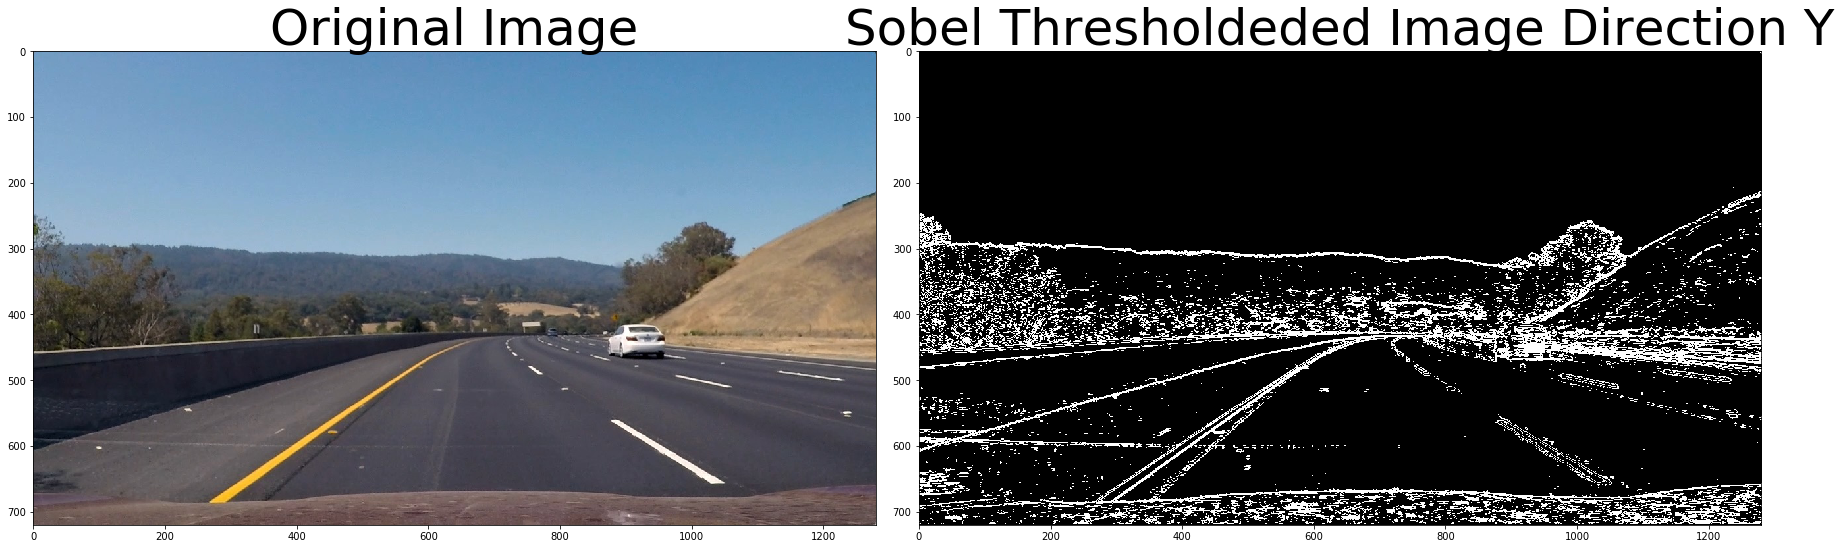

In [10]:
img = mpimg.imread('test_images/test3.jpg')
thresholded_img_x = abs_sobel_thresh(img, 'x', 10, 100)
thresholded_img_y = abs_sobel_thresh(img, 'y', 10, 100)
print_image(img, thresholded_img_x, 'OriginalImage', 'Sobel Thresholded Image Direction X', 'gray')
print_image(img, thresholded_img_y, 'Original Image', 'Sobel Thresholdeded Image Direction Y', 'gray')

# Magnitude Threshold

In [11]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

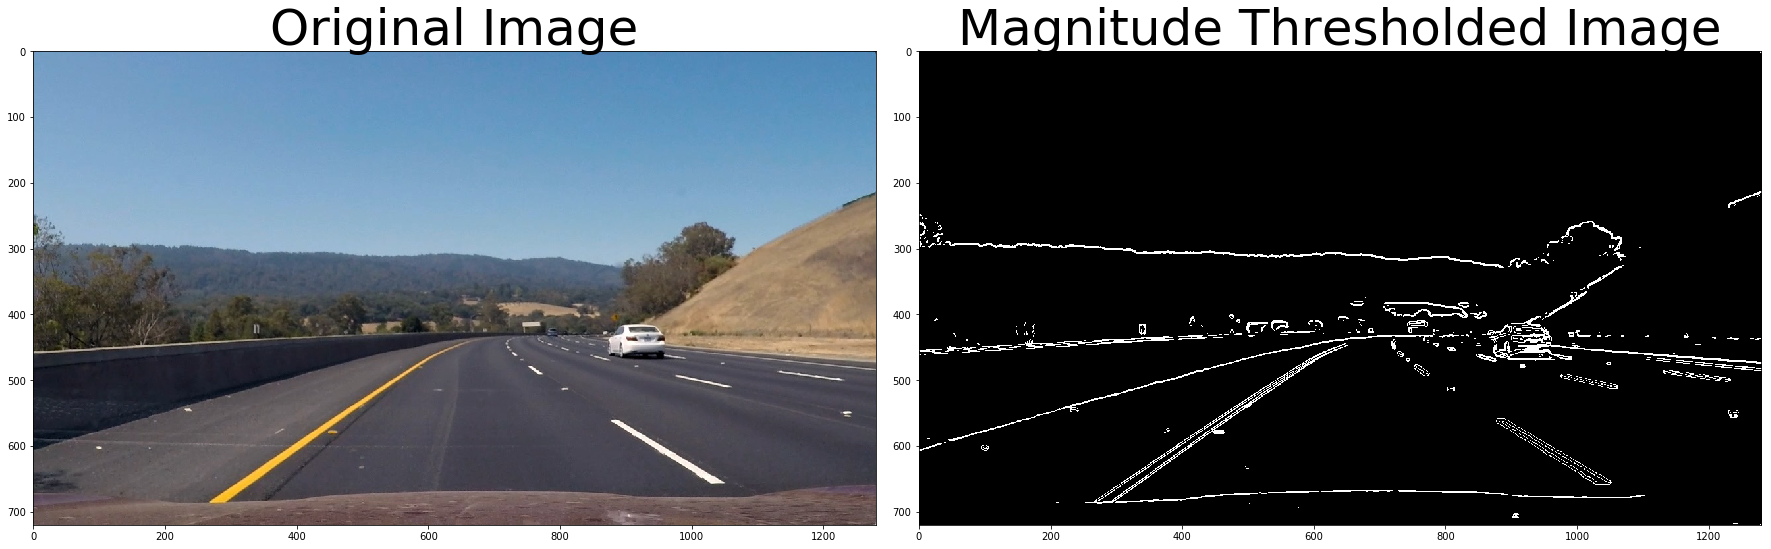

In [12]:
img = mpimg.imread('test_images/test3.jpg')
thresholded_img = mag_thresh(img, sobel_kernel=9, mag_thresh=(50,120))
print_image(img, thresholded_img, 'Original Image', 'Magnitude Thresholded Image', 'gray')

# Gradient Threshold

In [13]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

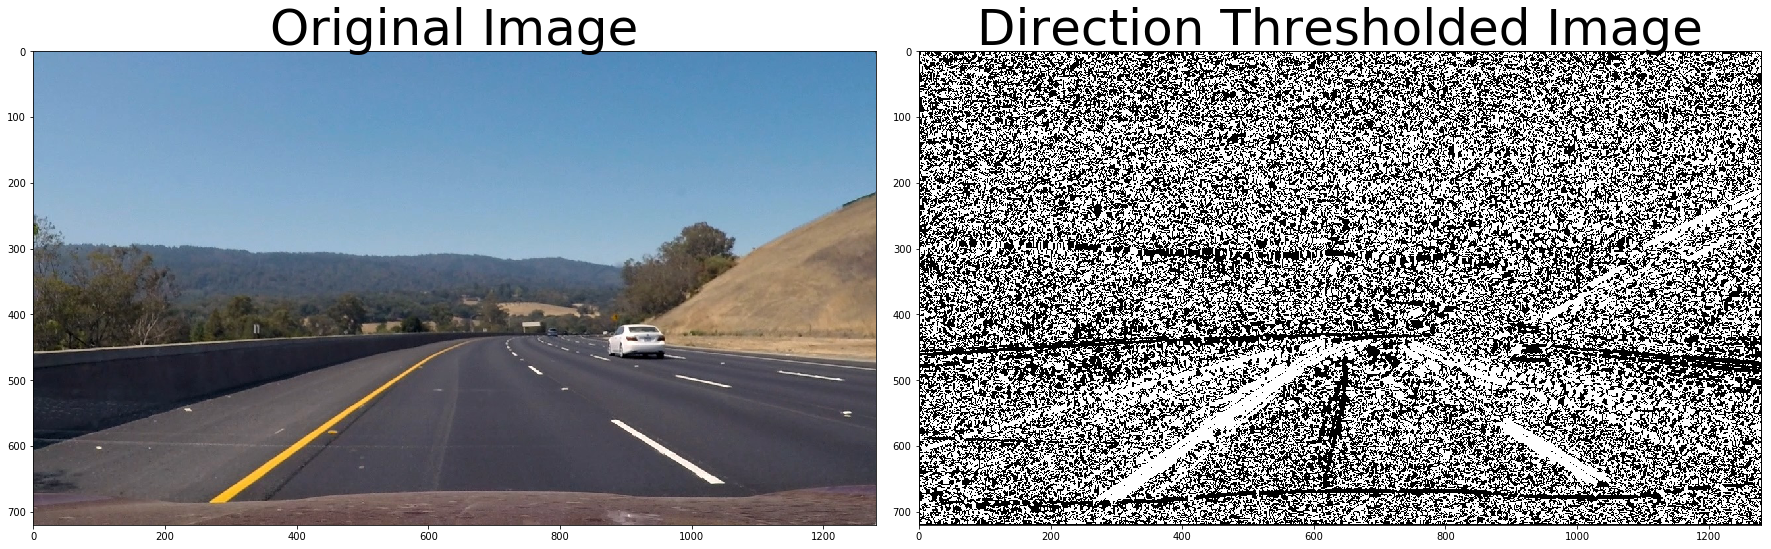

In [14]:
img = mpimg.imread('test_images/test3.jpg')
thresholded_img = dir_thresh(img, sobel_kernel=15, thresh=(0.6, 1.4))
print_image(img, thresholded_img, 'Original Image', 'Direction Thresholded Image', 'gray')

After experimenting numerous aspects of the gradient let's think about how we can use various aspects of the gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. Most importantly the question is how we can use thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines.

# Color Threshold

As it was shown in the Lessons there are various color thresholds that can be applied to find lane lines in images. It was also shown how and why the HLS color space can be more robust highlighting the lines regardless of lighting conditions, constrast, and other factors that might lead to recognize lanes in images incorrectly. Based on the examples in the Lessons I will apply the thresholding on the S-channel of the HLS image.

In [15]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

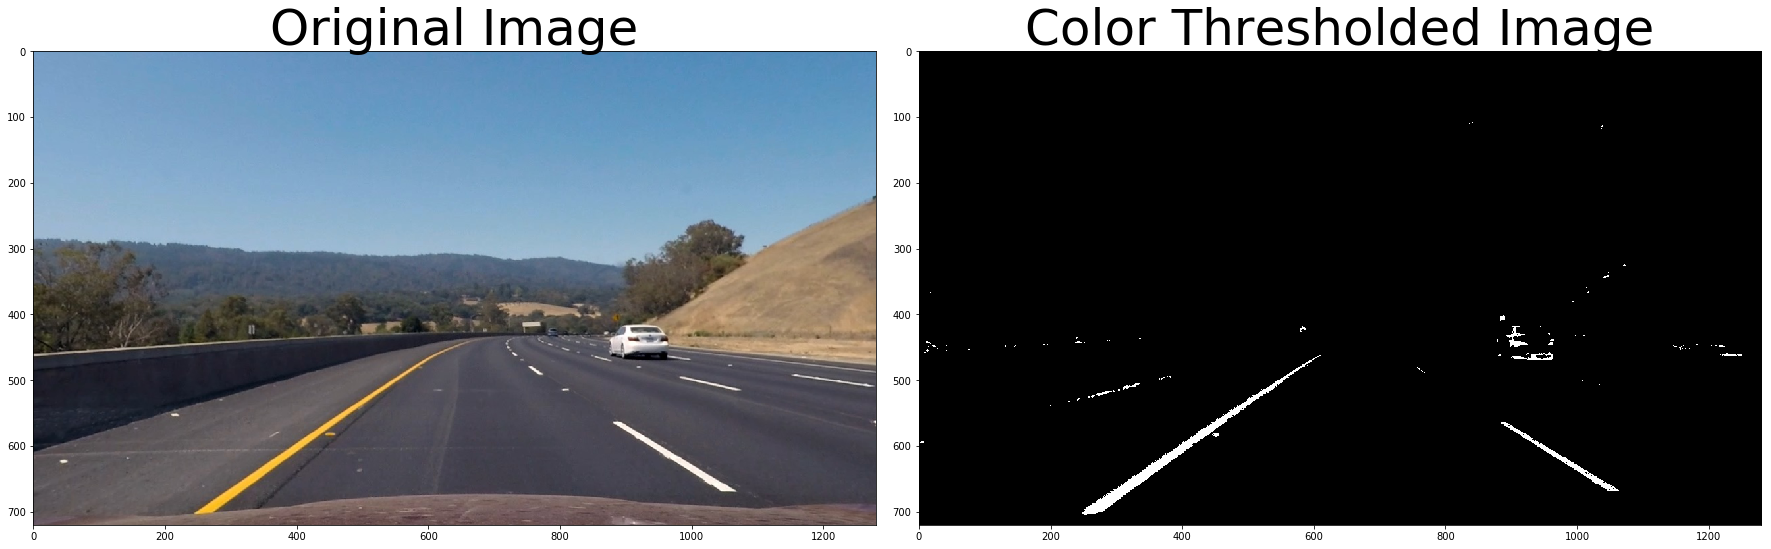

In [16]:
img = undistort(mpimg.imread('test_images/test3.jpg'))
s_channel_img = hls_select(img, thresh=(120,255))
print_image(img, s_channel_img, 'Original Image', 'Color Thresholded Image', cmap='gray')

# Thresholding and Warping Combined

In [17]:
def preproc_img(img):
    # Undistort image
    img = undistort(img)

    # Sobel threshold
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=70)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=10, thresh_max=70)

    # Magnitude threshold
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 100))

    #Gradient threshold
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.9, 1.1))

    #Color threshold
    hls_binary = hls_select(img, (120, 255))

    # Combine
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) | (hls_binary == 1))] = 1
    
    img_warp = warp(combined)
    
    return img_warp

# Perspective transform on thresholded binary image

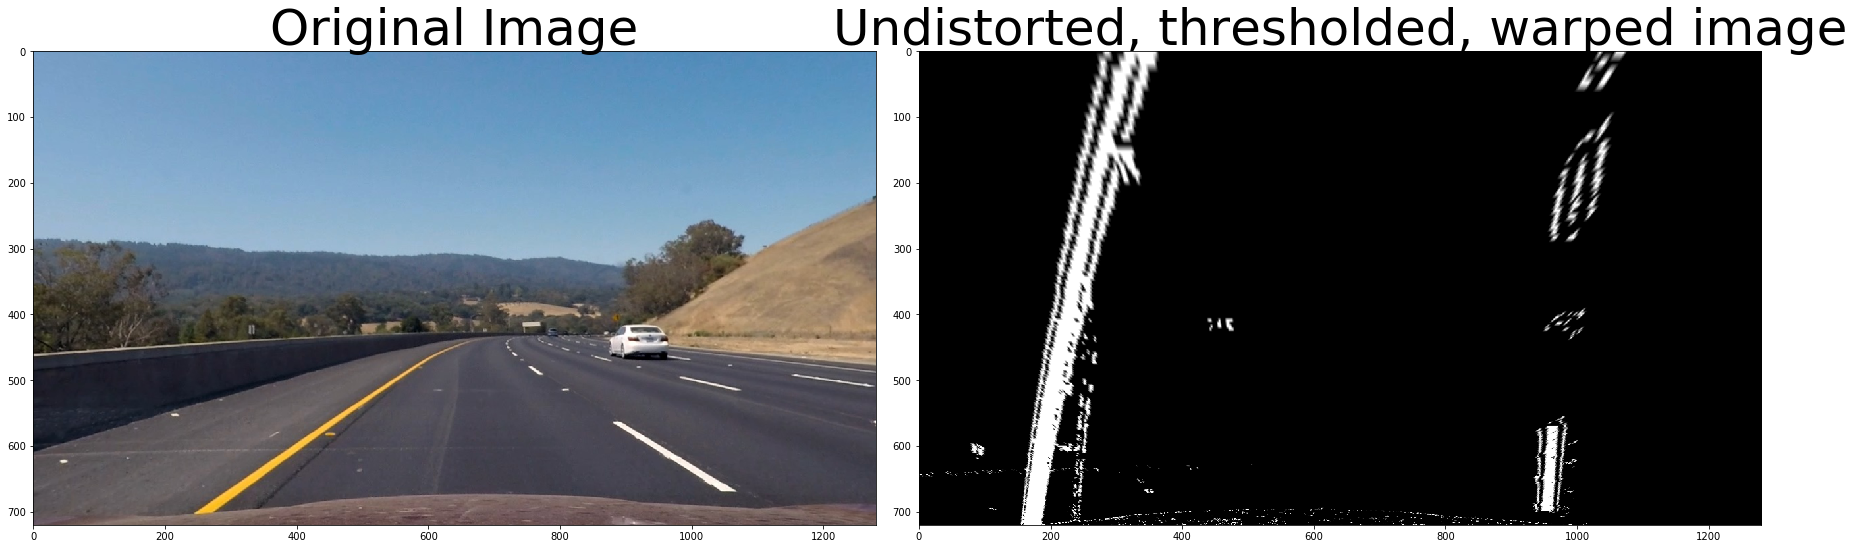

In [18]:
binary_warped= preproc_img(img)
print_image(img, preproc_img(img), 'Original Image', "Undistorted, thresholded, warped image", 'gray')

# Identifying the lane lines
# Histogram

One way to decide which pixels are part of the lines and which belong to the left and which to the right is taking a histogram along all the columns in the lower half of the image. The peaks in the histogram indicate where the lane lines are. 

188 956


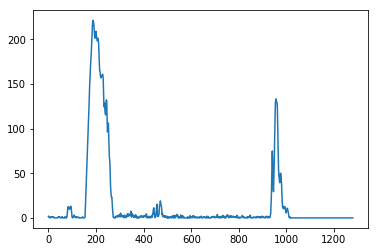

In [19]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

# Sliding window search and Polynomial fitting

Using the two histogram peaks as starting point in my thresholded binary image I can search for the lines. From the two starting points on the bottom sliding windows can be placed around the line centers, to find and follow the lines up to the top of the image.

In [25]:
def get_line_generation(nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if(leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0):
        return None, None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx

In [59]:
def brute_search(img_warped, display):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    left_fitx, right_fitx = get_line_generation(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    
    if(display==True):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fitx, right_fitx

In [61]:
brute_search(binary_warped, False)

(array([ 321.27645074,  321.00211497,  320.72800266,  320.4541138 ,
         320.18044839,  319.90700643,  319.63378793,  319.36079288,
         319.08802128,  318.81547314,  318.54314844,  318.27104721,
         317.99916942,  317.72751509,  317.45608421,  317.18487679,
         316.91389281,  316.64313229,  316.37259523,  316.10228161,
         315.83219145,  315.56232475,  315.29268149,  315.02326169,
         314.75406534,  314.48509245,  314.21634301,  313.94781702,
         313.67951448,  313.4114354 ,  313.14357977,  312.87594759,
         312.60853887,  312.3413536 ,  312.07439178,  311.80765342,
         311.54113851,  311.27484705,  311.00877904,  310.74293449,
         310.47731339,  310.21191575,  309.94674155,  309.68179081,
         309.41706353,  309.15255969,  308.88827931,  308.62422239,
         308.36038891,  308.09677889,  307.83339232,  307.57022921,
         307.30728955,  307.04457334,  306.78208058,  306.51981128,
         306.25776543,  305.99594303,  305.73434

In [ ]:
def radius_of_curvature(x_values):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

# Skip the sliding windows step once you know where the lines are

There is no need to search for the lane lines in each frame if they can be found once and tracked in the following frames. Let's search in a margin of 50 pixels of the previously detected lane lines. 

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
def final_pipeline(image):
    #Global variables to store the previous frame's polynomial coefficient
    global polyfit_right
    global polyfit_left
    
    #Global variables to store previous line coordinates in order to average over frames
    global previous_right
    global previous_left
    
    global mean_diff_between_lanes
    
    warped = preproc_img(image)
    out_img = np.dstack((warped, warped, warped))*255
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    y_points = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_fitx, right_fitx = brute_search(warped)
    else:
        brute = False
        margin = 100
        left_lane_inds = ((nonzerox > (polyfit_left[0]*(nonzeroy**2) + polyfit_left[1]*nonzeroy + polyfit_left[2] - margin)) 
                          & (nonzerox < (polyfit_left[0]*(nonzeroy**2) + polyfit_left[1]*nonzeroy + polyfit_left[2] + margin)))
        right_lane_inds = ((nonzerox > (polyfit_right[0]*(nonzeroy**2) + polyfit_right[1]*nonzeroy + polyfit_right[2] - margin)) 
                           & (nonzerox < (polyfit_right[0]*(nonzeroy**2) + polyfit_right[1]*nonzeroy + polyfit_right[2] + margin))) 
        left_fitx, right_fitx = get_line_generation(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
        
        if(left_fitx is None or right_fitx is None):
            if not brute:
                left_fitx, right_fitx = brute_search(warped)
        
        missed_line = False
        
        if(left_fitx is None or right_fitx is None):
            missed_line = True
        else:
            mean_difference = np.mean(right_fitx - left_fitx)
            if(mean_diff_between_lanes == 0):
                mean_diff_between_lanes = mean_difference
            
            if(mean_difference < 0.7*mean_diff_between_lanes or mean_difference > mean_diff_between_lanes*1.3):
                missed_line = True
                if not brute:
                    left_fitx, right_fitx = brute_search(warped)
                    if(left_fitx is None or right_fitx is None):
                        missed_line = True
                    else:
                        mean_difference = np.mean(right_fitx - left_fitx)
                        if(mean_difference < 0.7*mean_diff_between_lanes or mean_difference > mean_diff_between_lanes*1.3):
                            missed_line = True
                        else:
                            missed_line = False
            else:
                missed_line = False
        if missed_line:
            polyfit_left = None
            polyfit_right = None
            if len(previous_left) == 0 and len(previous_right) == 0:
                return image
            else:
                left_fitx = previous_left[-1]
                right_fitx = previous_right[-1]
        else:
            previous_left, left_fitx = get_averaged_line(previous_left, left_fitx)
            previous_right, right_fitx = get_averaged_line(previous_right, right_fitx)
            mean_difference = np.mean(right_fitx - left_fitx)
            mean_diff_between_lanes = 0.9*mean_diff_between_lanes + 0.1*mean_difference
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        
        #compute the radius of the curvature
        left_curve_rad = meas

# Computing the radius of curvature and center offset.

The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.
The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m